# pySCENIC

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp

In [19]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/home/datastore2/jackyyam/projects/craniofaical-genomics/scenic_2025q4"
os.chdir(wdir)

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "outputs/ecto_filtered_scenic.loom"

# path to pyscenic output
f_pyscenic_output = "outputs/pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'outputs/ecto_scenic_integrated-output.loom'

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.10.9
scanpy      1.10.3
-----
PIL                         10.4.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        24.2.0
attrs                       24.2.0
babel                       2.16.0
certifi                     2024.08.30
cffi                        1.17.1
charset_normalizer          3.4.0
cloudpickle                 3.1.0
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
cytoolz                     1.0.0
dask                        2024.2.1
dateutil                    2.9.0.post0
debugpy                     1.8.7
decorator                   5.1.1
defusedxml                  0.7.1
dill                        0.3.9
exceptiongroup              1.2.2
executing                   2.1.0
fastjsonschema              NA
fqdn                        NA
h5py                        3.12.1
idna                        3.10
igraph                     

/home/jacky/miniconda3/envs/scenic1.01/lib/python3.10/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


In [4]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 30

## Expression data import

In [5]:
### Read data
adata = sc.read_h5ad('data/gse155121_ecto_cleaned_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 8575 × 8108
    obs: 'stage', 'SampleID', 'region', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_RPS', 'pct_counts_RPS', 'total_counts_RPL', 'pct_counts_RPL', 'doublet_score', 'predicted_doublet', 'leiden', 'celltype'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'RPS', 'RPL', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'SampleID_colors', 'celltype_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'region_colors', 'stage_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_palantir', 'X_pca', 'X_pca2d', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

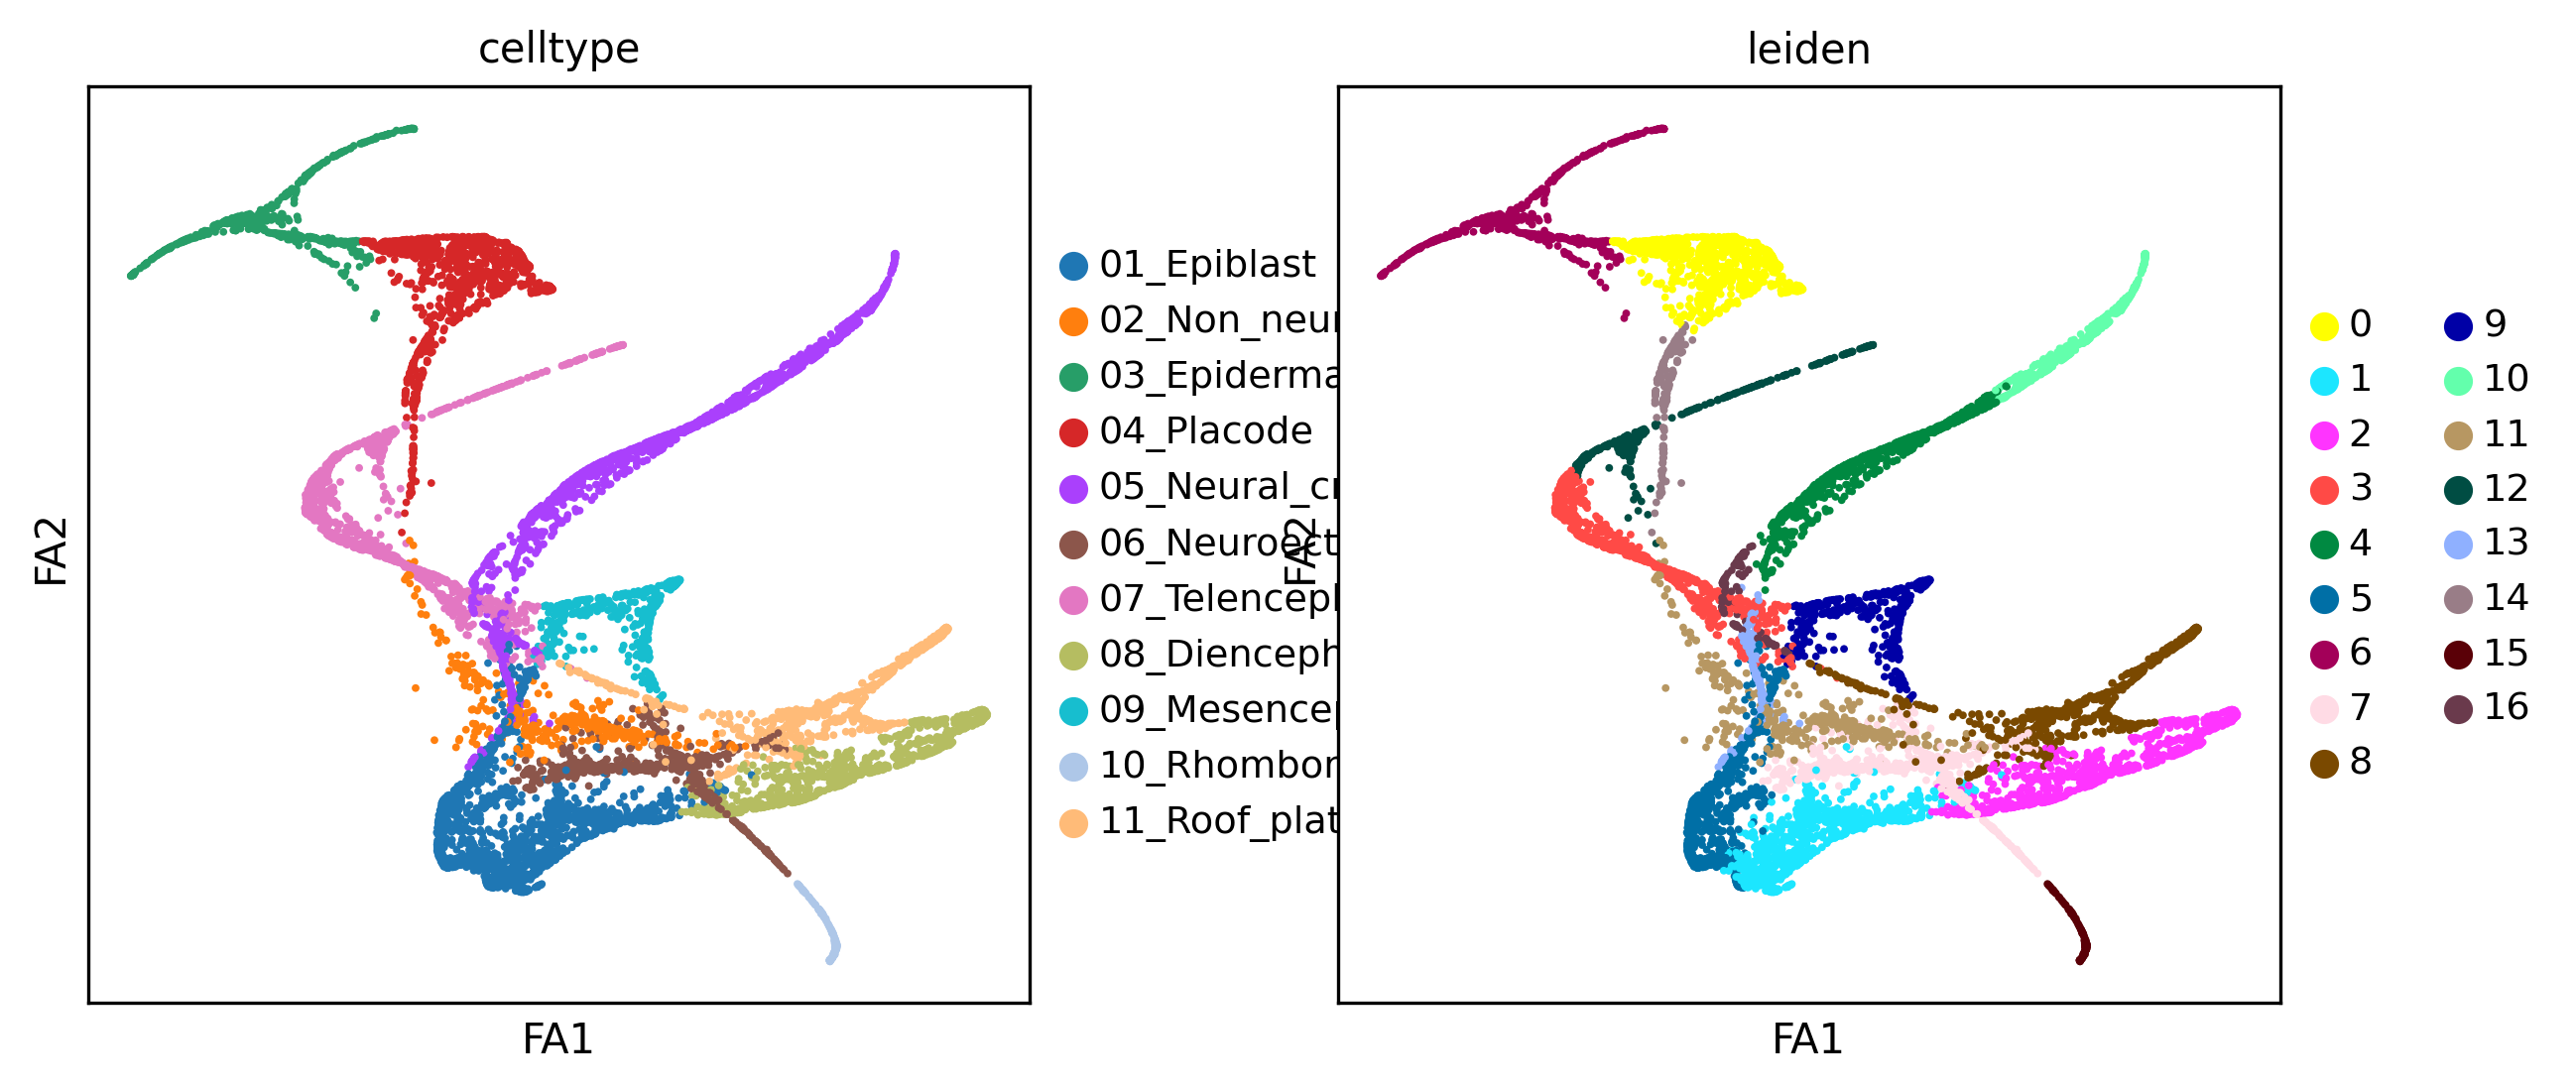

In [24]:
sc.pl.draw_graph(adata,color=['celltype', 'leiden'])

#### write to an loom file

In [7]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

## SCENIC steps

#### STEP 1: Gene regulatory network inference, and generation of co-expression modules

In [8]:
# transcription factors list
f_tfs = "/home/datastore2/jackyyam/resources/scenic/allTFs_hg38.txt" # human

In [9]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o outputs/adj.csv --num_workers 30


2025-10-03 20:58:54,241 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-10-03 20:58:55,258 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
/home/jacky/miniconda3/envs/scenic1.01/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34097 instead
  warnings.warn(
preparing dask client
parsing input
creating dask graph
30 partitions
computing dask graph
/home/jacky/miniconda3/envs/scenic1.01/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 269.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
not shutting down client, client was created externally
finished
2025-10-03 21:10:02,222 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jacky/miniconda

In [11]:
adjacencies = pd.read_csv("outputs/adj.csv", index_col=False, sep='\t')

In [12]:
adjacencies.head()

TF,target,importance
0  HOXB9,HOXB-AS3,21.24118140620422
1   NR2F1,MARCKS,19.524387569043586
2      GRHL2,KRT8,18.72257096613515
3     GRHL2,KRT19,16.82031472120251
4     JUND,IGFBP2,16.32428415843888

#### STEP 2-3: Regulon prediction aka cisTarget from CLI

In [13]:
import glob
# ranking databases
f_db_glob = "/home/datastore2/jackyyam/resources/scenic/homo_sapiens/hg19/refseq_r45/mc9nr/gene_based/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/home/datastore2/jackyyam/resources/scenic/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [18]:
!pyscenic ctx outputs/adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output outputs/reg.csv \
    --mask_dropouts \
    --num_workers 30


2025-10-04 00:07:26,010 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-10-04 00:07:27,087 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-10-04 00:07:28,220 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-10-04 00:07:28,317 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2025-10-04 00:07:30,813 - pyscenic.utils - INFO - Creating modules.

2025-10-04 00:08:11,370 - pyscenic.cli.pyscenic - IN

### STEP 4: Cellular enrichment (aka AUCell) from CLI

In [20]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    outputs/reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 30


2025-10-04 00:29:29,322 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-10-04 00:29:30,388 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2025-10-04 00:29:35,943 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2025-10-04 00:29:47,342 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/home/jacky/miniconda3/envs/scenic1.01/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


### Visualization of SCENIC's AUC matrix

In [7]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [11]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "outputs/scenic_umap.txt", sep='\t')


### Integrate the output

In [20]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'outputs/scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'outputs/scenic_tsne.txt', sep='\t', header=0, index_col=0 )

In [21]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

/tmp/ipykernel_295788/1306291957.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')


In [22]:
drawgraphDF = pd.DataFrame(adata.obsm['X_draw_graph_fa'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [25]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy FA2"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy leiden",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "celltype",
        "values": list(set( adata.obs['celltype'].astype(np.str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i, ct in enumerate(sorted(set(adata.obs['celltype']))):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Cell Types {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
celltype_to_id = {ct: i for i, ct in enumerate(sorted(set(adata.obs['celltype'])))}
clusterings["0"] = adata.obs['celltype'].map(celltype_to_id).values.astype(np.int64)

/tmp/ipykernel_295788/2732773819.py:47: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "values": list(set( adata.obs['celltype'].astype(np.str) ))


In [26]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [27]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['total_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Cell_clusters_Scanpy": np.array( adata.obs['celltype'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['pct_counts_MT'].values),
    "Embedding": dfToNamedMatrix(drawgraphDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['celltype'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg19',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [28]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file